In [2]:
import os 
import json 
import shutil 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

## Reduce data 

We try to reduce the data to (20000, 1000, 1000) for (train, val, test) of each folder. The reduced data saved to `./dataset/reduced_data/`.

In [18]:
TRAIN_SIZE = 20000
VAL_SIZE = 1000
TEST_SIZE = 1000

In [19]:
reduced_data_path = 'dataset/reduced_data'
os.makedirs(reduced_data_path, exist_ok=True)

In [20]:
main_folders = ['clsdata(1031)', 'piedata(1008)']
sub_folders = ['annotations', 'images']  
image_sub_folders = ['train2019', 'val2019', 'test2019']

sub_dir_map = {
    main_folders[0]: "cls",
    main_folders[1]: "pie",
}

for main in main_folders:
    parent_dir = os.path.join(reduced_data_path, main, sub_dir_map[main])

    for sub in sub_folders:
        sub_dir_path = os.path.join(parent_dir, sub)
        os.makedirs(sub_dir_path, exist_ok=True) 

        if sub == "images":
            for image_sub in image_sub_folders:
                os.makedirs(os.path.join(sub_dir_path, image_sub), exist_ok=True)

Make a helper function to reduce data in bar, pie, line

In [21]:
def reduced_annotation(data, size):
    """ 
    Reduces the annotation data to the given size

    Args:
        data (dict): The data to be reduced
        size (int): The size to reduce the data to 

    Returns:
        dict: The reduced data
    """
    annotations_df = pd.DataFrame(data['annotations'])
    images_df = pd.DataFrame(data['images'])    
    
    # Take the first size number of images
    ids1 = images_df['id']
    ids2 = annotations_df['image_id']

    # Intersection of the two sets
    ids = ids1[ids1.isin(ids2)]
    ids = ids.sort_values()
    ids = ids[:size]

    # Filter the annotations based on the image ids
    reduced_annotations = annotations_df[annotations_df['image_id'].isin(ids)]
    reduced_images = images_df[images_df['id'].isin(ids)]
    
    data['images'] = json.loads(reduced_images.to_json(orient="records"))
    data['annotations'] = json.loads(reduced_annotations.to_json(orient="records"))

    return data

another helper function to reduce data in cls (we can use the previous function but it just take 10000 bar data)

In [22]:
def reduced_annotation_cls(data, size, RATES = [0.33, 0.33, 0.34]):
    """
    Reduces the cls data to the given size 
    Keep the rate of 0 1 and 2 the same (0.33, 0.33, 0.34)
    
    Args:
        data (dict): The data to be reduced
        size (int): The size to reduce the data to 

    Returns:
        dict: The reduced data
    """

    annotations_df = pd.DataFrame(data['annotations'])
    images_df = pd.DataFrame(data['images'])    

    # Take each class index for images and annotations
    cls0_image_ids = images_df[images_df['data_type'] == 0]['id']
    cls1_image_ids = images_df[images_df['data_type'] == 1]['id']
    cls2_image_ids = images_df[images_df['data_type'] == 2]['id']

    cls0_annotation_ids = annotations_df[annotations_df['category_id'] == 0]['image_id']
    cls1_annotation_ids = annotations_df[annotations_df['category_id'] == 1]['image_id']
    cls2_annotation_ids = annotations_df[annotations_df['category_id'] == 2]['image_id']

    # Take the intersection of image ids and annotation ids
    cls0_ids = cls0_image_ids[cls0_image_ids.isin(cls0_annotation_ids)]
    cls1_ids = cls1_image_ids[cls1_image_ids.isin(cls1_annotation_ids)]
    cls2_ids = cls2_image_ids[cls2_image_ids.isin(cls2_annotation_ids)]

    # Take the first size * RATE of the ids
    reduced_cls0_ids = cls0_ids[:int(size * RATES[0])]
    reduced_cls1_ids = cls1_ids[:int(size * RATES[1])]
    reduced_cls2_ids = cls2_ids[:int(size * RATES[2])]

    ids = pd.concat([reduced_cls0_ids, reduced_cls1_ids, reduced_cls2_ids])

    # Filter the annotations based on the image ids
    reduced_annotations = annotations_df[annotations_df['image_id'].isin(ids)]
    reduced_images = images_df[images_df['id'].isin(ids)]

    data['images'] = json.loads(reduced_images.to_json(orient="records"))
    
    data['annotations'] = json.loads(reduced_annotations.to_json(orient="records"))
    
    return data
    

In [23]:
data_path = 'dataset/data'
output_path = 'dataset/reduced_data'

In [24]:
%%time

for folder in os.listdir(data_path):
    main_folder_path = os.path.join(data_path, folder)

    # Check if it is a folder
    if not os.path.isdir(main_folder_path):
        continue

    sub_folders = os.listdir(main_folder_path)

    sub_folder = sub_folders[0] 
    sub_folder_path = os.path.join(main_folder_path, sub_folder)
    annotations_path = os.path.join(sub_folder_path, "annotations")


    output_annotations_path = os.path.join(output_path, folder, sub_folder, "annotations")

    for file_name in os.listdir(annotations_path):
        if file_name.endswith(".json"):
            input_file = os.path.join(annotations_path, file_name)
            output_file = os.path.join(output_annotations_path, file_name)

            with open(input_file, "r", encoding="utf-8") as f:
                data = json.load(f)

            if "train" in file_name:
                size = TRAIN_SIZE
            elif "val" in file_name:
                size = VAL_SIZE
            elif "test" in file_name:
                size = TEST_SIZE

            # Check startwith cls
            if folder.startswith("cls"):
                reduced_json = reduced_annotation_cls(data, size)
            else:
                reduced_json = reduced_annotation(data, size)

            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(reduced_json, f, ensure_ascii=False)


CPU times: user 6.88 s, sys: 533 ms, total: 7.41 s
Wall time: 7.54 s


## Images folder

In [25]:
def copy_images(data, type, split):
    """
    Copies the images from the original dataset to the reduced dataset

    Args:
        data (dict): The data containing the image filenames
        type (str): The type of the data (bar, pie, line, cls)
        split (str): The split of the data (train, val, test)
    """
    image_filenames = {img["file_name"] for img in data.get("images", [])}

    if type == 'pie':
        if split == 'train':
            src_path = 'dataset/data/piedata(1008)/pie/images/train2019'
            copy_path = 'dataset/reduced_data/piedata(1008)/pie/images/train2019'
        elif split == 'val':
            src_path = 'dataset/data/piedata(1008)/pie/images/val2019'
            copy_path = 'dataset/reduced_data/piedata(1008)/pie/images/val2019'
        elif split == 'test':
            src_path = 'dataset/data/piedata(1008)/pie/images/test2019'
            copy_path = 'dataset/reduced_data/piedata(1008)/pie/images/test2019'

    elif type == 'cls':
        if split == 'train':
            src_path = 'dataset/data/clsdata(1031)/cls/images/train2019'
            copy_path = 'dataset/reduced_data/clsdata(1031)/cls/images/train2019'
        elif split == 'val':
            src_path = 'dataset/data/clsdata(1031)/cls/images/val2019'
            copy_path = 'dataset/reduced_data/clsdata(1031)/cls/images/val2019'
        elif split == 'test':
            src_path = 'dataset/data/clsdata(1031)/cls/images/test2019'
            copy_path = 'dataset/reduced_data/clsdata(1031)/cls/images/test2019'

    copy_image_path = None  
    copied_count = 0

    for image_name in image_filenames:
        src_image_path = os.path.join(src_path, image_name)
        copy_image_path = os.path.join(copy_path, image_name)

        if os.path.exists(src_image_path):  
            shutil.copy2(src_image_path, copy_image_path)
            copied_count += 1
        else:
            print(f"Cannot found any images in: {src_image_path}")

    if copied_count > 0:
        print(f"{copied_count}/{len(image_filenames)} images copied to {copy_path}\n")
    else:
        print(f"No images are copied to {copy_path}\n")

In [3]:
# Pie
with open('dataset/reduced_data/piedata(1008)/pie/annotations/instancesPie(1008)_train2019.json', "r", encoding="utf-8") as f:
    pie_train = json.load(f)

with open('dataset/reduced_data/piedata(1008)/pie/annotations/instancesPie(1008)_val2019.json', "r", encoding="utf-8") as f:
    pie_val = json.load(f)

with open('dataset/reduced_data/piedata(1008)/pie/annotations/instancesPie(1008)_test2019.json', "r", encoding="utf-8") as f:
    pie_test = json.load(f)
    
# Cls
with open('dataset/reduced_data/clsdata(1031)/cls/annotations/instancesCls(1031)_train2019.json', "r", encoding="utf-8") as f:
    cls_train = json.load(f)

with open('dataset/reduced_data/clsdata(1031)/cls/annotations/instancesCls(1031)_val2019.json', "r", encoding="utf-8") as f:
    cls_val = json.load(f)

with open('dataset/reduced_data/clsdata(1031)/cls/annotations/instancesCls(1031)_test2019.json', "r", encoding="utf-8") as f:
    cls_test = json.load(f)

In [27]:
%%time
copy_images(pie_train, 'pie', 'train')
copy_images(pie_val, 'pie', 'val')
copy_images(pie_test, 'pie', 'test')

copy_images(cls_train, 'cls', 'train')
copy_images(cls_val, 'cls', 'val')
copy_images(cls_test, 'cls', 'test')

20000/20000 images copied to dataset/reduced_data/piedata(1008)/pie/images/train2019

1000/1000 images copied to dataset/reduced_data/piedata(1008)/pie/images/val2019

1000/1000 images copied to dataset/reduced_data/piedata(1008)/pie/images/test2019

20000/20000 images copied to dataset/reduced_data/clsdata(1031)/cls/images/train2019

1000/1000 images copied to dataset/reduced_data/clsdata(1031)/cls/images/val2019

1000/1000 images copied to dataset/reduced_data/clsdata(1031)/cls/images/test2019

CPU times: user 1.56 s, sys: 3.58 s, total: 5.14 s
Wall time: 9.07 s


## COCO to YOLO format

Draw a image and it bbox

Image ID: 75015
File Name: fa2f25e357c5051b10a1f8589f33806a_d3d3LmluZWdpLm9yZy5teAkyMDAuMzMuMTA5LjU=.xls-11-0.png
Box 1: [392.0, 176.0, 250.0, 284.0, 280.0, 176.0]
Box 2: [250.0, 284.0, 232.0, 277.0, 280.0, 176.0]
Box 3: [232.0, 277.0, 213.0, 266.0, 280.0, 176.0]
Box 4: [213.0, 266.0, 187.0, 239.0, 280.0, 176.0]
Box 5: [187.0, 239.0, 168.0, 173.0, 280.0, 176.0]
Box 6: [168.0, 173.0, 258.0, 66.0, 280.0, 176.0]
Box 7: [258.0, 66.0, 392.0, 176.0, 280.0, 176.0]


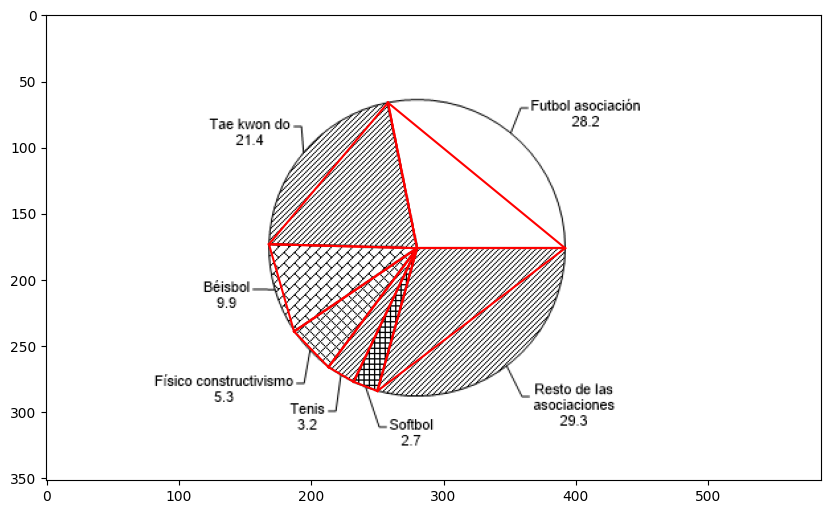

In [4]:
first_image = pie_val['images'][16]
idx = first_image['id']
file_name = first_image['file_name']
bboxs = [ann for ann in pie_val['annotations'] if ann['image_id'] == idx]

print(f"Image ID: {idx}")
print(f"File Name: {file_name}")
for i, b in enumerate(bboxs):
    print(f"Box {i + 1}: {b['bbox']}")
    
plt.figure(figsize=(10, 10))
image = plt.imread(f'dataset/reduced_data/piedata(1008)/pie/images/val2019/{file_name}')

for bbox in bboxs:
    arc_1_x, arc_1_y, arc_2_x, arc_2_y, center_x, center_y = bbox['bbox']
    plt.plot([arc_1_x, arc_2_x], [arc_1_y, arc_2_y], 'r')
    plt.plot([arc_2_x, center_x], [arc_2_y, center_y], 'r')
    plt.plot([center_x, arc_1_x], [center_y, arc_1_y], 'r')
    
plt.imshow(image)

In [5]:
reduced_annotation_pie_train = "./dataset/reduced_data/piedata(1008)/pie/annotations/instancesPie(1008)_train2019.json"
reduced_annotation_pie_val = "./dataset/reduced_data/piedata(1008)/pie/annotations/instancesPie(1008)_val2019.json"
reduced_annotation_pie_test = "./dataset/reduced_data/piedata(1008)/pie/annotations/instancesPie(1008)_test2019.json"

reduced_annotation_pieR_train = "./dataset/reduced_data/piedata(1008)/pie/annotations/instancesPieR(1008)_test2019.json"
reduced_annotation_pieR_val = "./dataset/reduced_data/piedata(1008)/pie/annotations/instancesPieR(1008)_val2019.json"
reduced_annotation_pieR_test = "./dataset/reduced_data/piedata(1008)/pie/annotations/instancesPieR(1008)_test2019.json"

In [6]:
pie_label_dir = "./dataset/reduced_data/piedata(1008)/pie/labels"
os.makedirs(pie_label_dir, exist_ok=True)

train_label_dir = os.path.join(pie_label_dir, "train2019")
val_label_dir = os.path.join(pie_label_dir, "val2019")
test_label_dir = os.path.join(pie_label_dir, "test2019")
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)

In [9]:
def create_label_file(annotation_path, label_dir):
    with open(annotation_path, "r") as f:
        data = json.load(f)
    
    for img in data["images"]:
        img_id = img["id"]
        img_width, im_height = img["width"], img["height"]
        img_name = img["file_name"]
        
        label_path = os.path.join(label_dir, f"{os.path.splitext(img_name)[0]}.txt")
        
        with open(label_path, 'w') as f:
            for annotation in data["annotations"]:
                if annotation["image_id"] == img_id:
                    category_id = annotation["category_id"]
                    x1, y1, x2, y2, xc, yc = annotation["bbox"]
                    
                    x1 = x1 / img_width
                    y1 = y1 / im_height
                    x2 = x2 / img_width
                    y2 = y2 / im_height
                    xc = xc / img_width
                    yc = yc / im_height
                    
                    f.write(f"{category_id} {x1} {y1} {x2} {y2} {xc} {yc}\n")

In [10]:
create_label_file(reduced_annotation_pie_train, train_label_dir)
create_label_file(reduced_annotation_pie_val, val_label_dir)
create_label_file(reduced_annotation_pie_test, test_label_dir)